In [2]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',header=None)

In [25]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [58]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.transform(['M', 'B'])

array([1, 0])

In [59]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Combining transformers and estimators in a pipeline

Instead of going through the fitting and transformation
steps for the training and test dataset separately, we can chain the StandardScaler ,
PCA , and LogisticRegression objects in a pipeline:

In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe_lr = Pipeline([('scl', StandardScaler()),('pca', PCA(n_components=2)),('clf', LogisticRegression(random_state=1))])
pipe_lr.fit(X_train, y_train)

print('Test accuracy: %.3f' %pipe_lr.score(X_test,y_test))


Test accuracy: 0.947


## Stratified k-fold cross validation

In [61]:
import numpy as np
from sklearn.cross_validation import StratifiedKFold
kfold = StratifiedKFold(y=y_train, n_folds=10, random_state=1)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1,
          np.bincount(y_train[train]), score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))


Fold: 1, Class dist.: [256 153], Acc: 0.891
Fold: 2, Class dist.: [256 153], Acc: 0.978
Fold: 3, Class dist.: [256 153], Acc: 0.978
Fold: 4, Class dist.: [256 153], Acc: 0.913
Fold: 5, Class dist.: [256 153], Acc: 0.935
Fold: 6, Class dist.: [257 153], Acc: 0.978
Fold: 7, Class dist.: [257 153], Acc: 0.933
Fold: 8, Class dist.: [257 153], Acc: 0.956
Fold: 9, Class dist.: [257 153], Acc: 0.978
Fold: 10, Class dist.: [257 153], Acc: 0.956

CV accuracy: 0.950 +/- 0.029


## Using the scikit-learn implementation of kfold cross validation

In [62]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=1)
print('CV accuracy scores : %s' %scores)


CV accuracy scores : [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]


In [63]:
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.950 +/- 0.029


## Debugging algorithms with learning and validation curves

### Diagnosing bias and variance problems with learning curves

let's first see how we can use the learning curve function
from scikit-learn to evaluate the model:

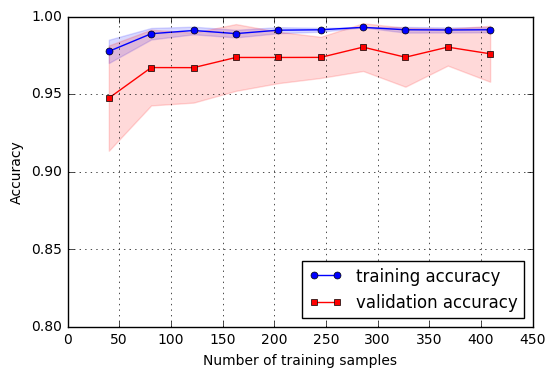

In [66]:
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve
pipe_lr = Pipeline([('scl',StandardScaler()),('clf', LogisticRegression(penalty='l2', random_state=0))])

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, X=X_train, y=y_train, train_sizes=np.linspace(0.1,1.0,10), cv=10, n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='red', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='red')
plt.grid()

plt.xlabel("Number of training samples")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.ylim([0.8,1.0])
plt.show()

By default, the learning_curve
function uses stratified k-fold cross-validation to calculate the cross-validation
accuracy

### Addressing overfitting and underfititng with validation curves

Validation curves are related to
learning curves, but instead of plotting the training and test accuracies as functions
of the sample size, we vary the values of the model parameters, for example, the
inverse regularization parameter C in logistic regression. Let's go ahead and see
how we create validation curves via sckit-learn:

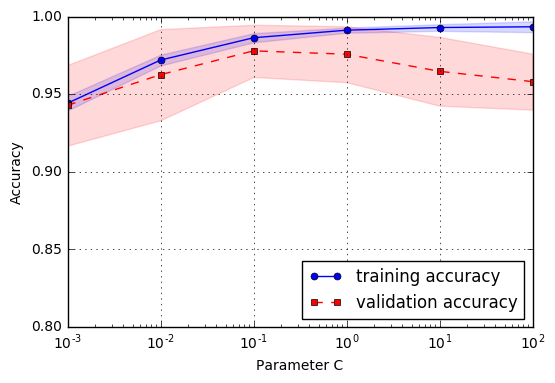

In [72]:
from sklearn.learning_curve import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator=pipe_lr, X=X_train, y=y_train, param_name='clf__C', param_range=param_range, cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean,linestyle='--', color='red', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='red')
plt.grid()
plt.xscale('log')
plt.xlabel("Parameter C")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.ylim([0.8,1.0])
plt.show()

Similar to the learning_curve function, the validation_curve function uses
stratified k-fold cross-validation by default to estimate the performance of the model
if we are using algorithms for classification.

## Fine tunning machine learning model via grid search

In this section, we will take a look at a
powerful hyperparameter optimization technique called grid search that can further
help to improve the performance of a model by finding the optimal combination of
hyperparameter values.

The approach of grid search is quite simple, it's a brute-force exhaustive search
paradigm where we specify a list of values for different hyperparameters, and the
computer evaluates the model performance for each combination of those to obtain
the optimal set:

In [74]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
pipe_svc = Pipeline([('scl', StandardScaler()),('clf', SVC(random_state=1))])

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'clf__C': param_range,
               'clf__kernel': ['linear']},
              {'clf__C': param_range,
              'clf__gamma': param_range,
              'clf__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)

0.978021978022


In [75]:
print(gs.best_params_)

{'clf__C': 0.1, 'clf__kernel': 'linear'}


## Algorithm selection with nested cross validation

Using k-fold cross-validation in combination with grid search is a useful approach
for fine-tuning the performance of a machine learning model by varying its
hyperparameters values as we saw in the previous subsection. If we want to select
among different machine learning algorithms though, another recommended
approach is nested cross-validation

In scikit-learn, we can perform nested cross-validation as follows:

In [76]:
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)
scores = cross_val_score(gs, X, y, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

CV accuracy: 0.972 +/- 0.012


The returned average cross-validation accuracy gives us a good estimate of what
to expect if we tune the hyperparameters of a model and then use it on unseen data.
For example, we can use the nested cross-validation approach to compare an
SVM model to a simple decision tree classifier; for simplicity, we will only tune
its depth parameter:

## Reading a Confusion Matrix

Confusion matrix, a matrix that lays out the performance of a learning algorithm.
The confusion matrix is simply a square matrix that reports the counts of the true
positive, true negative, false positive, and false negative predictions of a classifier,
as shown in the following figure:

Although these metrics can be easily computed manually by comparing the true and
predicted class labels, scikit-learn provides a convenient confusion_matrix function
that we can use as follows:

In [83]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]
